## Import initial parameters

In [24]:
import matplotlib.pyplot as plt
import numpy as np

from spatial_parms import initialize_spatial_parms

from parameters_animals import initialize_animal_parms
from parameters_vegetation import initialize_veg_parms

from initial_distribution import initial_sp_distribution
from initial_distribution import plot_species_distribution
from Diffusion_parameters import initialize_diffusion_parms
from diffusion_fct import compute_norm_score_patch

from intermediate import log_intermediates

Nx, Ny, dx, dy, dt, Nt, Lx, Ly = initialize_spatial_parms()
V1, V2, H1, H2, P, k_V1, k_V2, mask_V2, mask_V1 = initial_sp_distribution(Nx, Ny)
u_croiss, v_croiss, k_U_val, k_V_norm, k_U_max = initialize_veg_parms()

rho_H1, a_H2, a_H1, h_V2H2, e_V1, e_V2, h_V1H1, h_V2H1, h_V1H2, mu_H2, mu_H1, epsi_AJ, chi_H2, chi_H1, k_H2, k_H1, a_PH2, a_PH1, h_PH1, h_PH2, mu_P, phi_P, h_P, chi_P, epsi_H1H2 = initialize_animal_parms(k_U_val, k_V_norm, k_U_max)

sigma_H1, sigma_H2, eta_H1, eta_H2, alpha_H2H2, alpha_H1H1, alpha_H2V1, alpha_H2V2, alpha_H1V2, alpha_H1V1, alpha_PH2, alpha_PH1 = initialize_diffusion_parms()


## Define landscape barrier

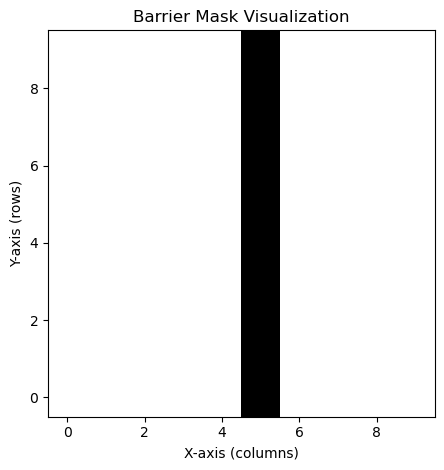

In [25]:
from Landscape_disturbances_mask import create_barrier_mask
import matplotlib.pyplot as plt


barrier_mask = create_barrier_mask((Nx, Ny), orientation='vertical', thickness=1, position='center')

# barrier_mask = None

# Plot it
plt.imshow(barrier_mask, cmap='gray_r', origin='lower')
plt.title('Barrier Mask Visualization')
plt.xlabel('X-axis (columns)')
plt.ylabel('Y-axis (rows)')
plt.grid(False)
plt.tight_layout()
plt.show()



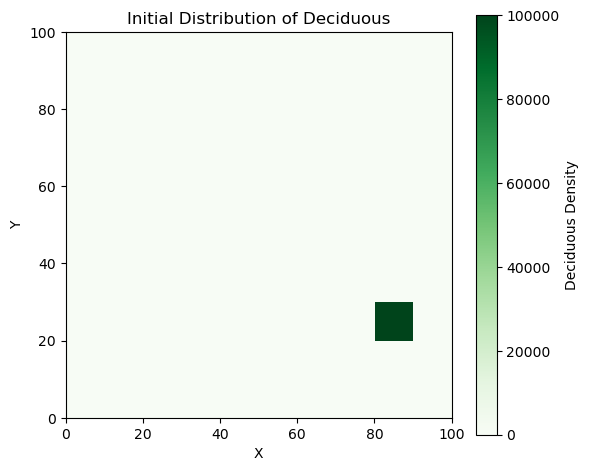

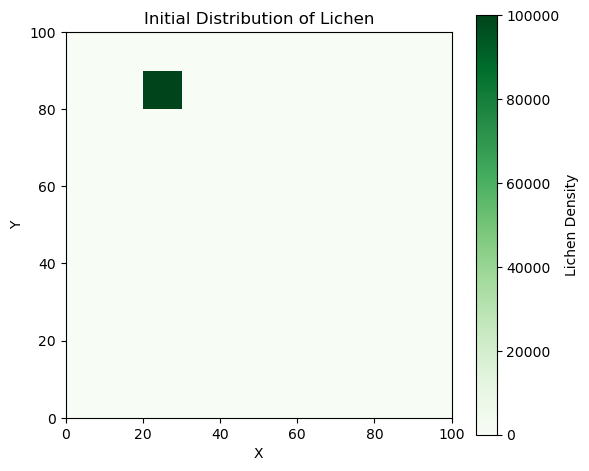

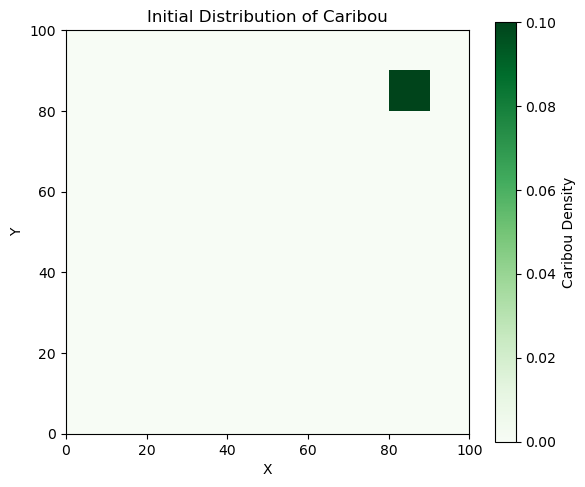

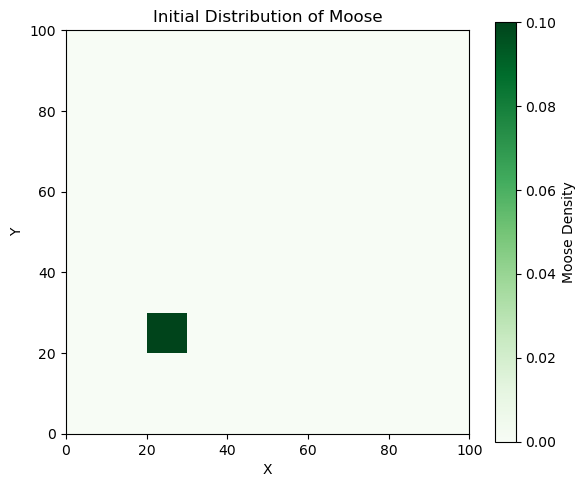

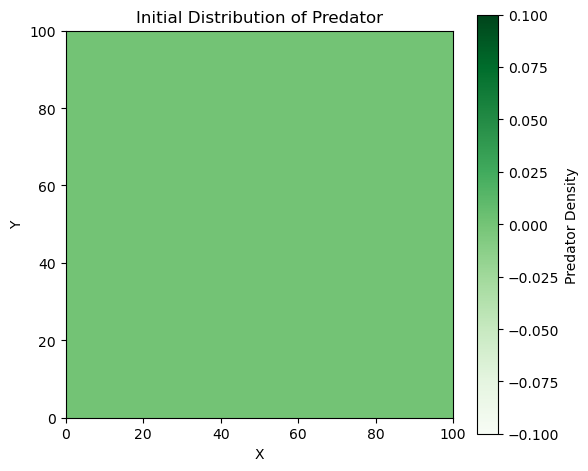

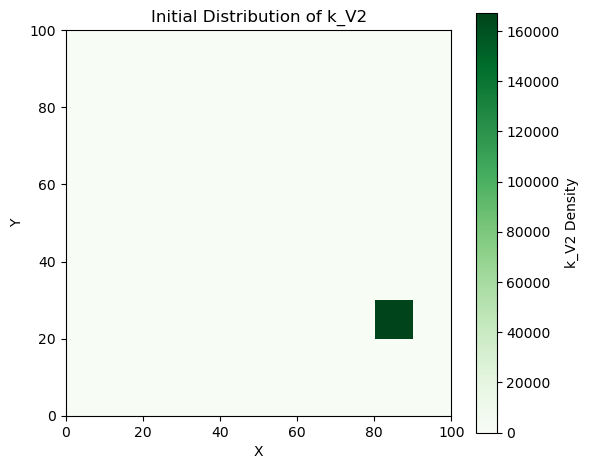

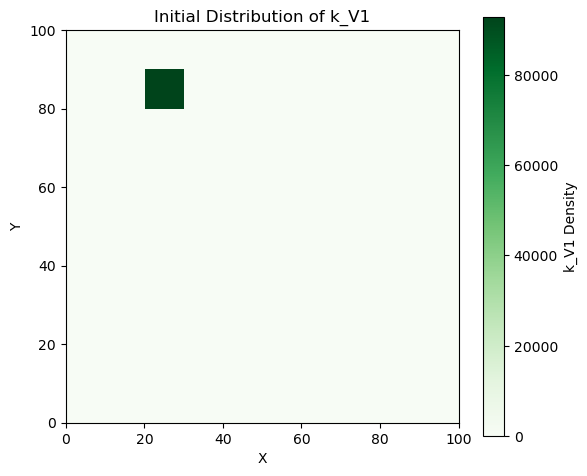

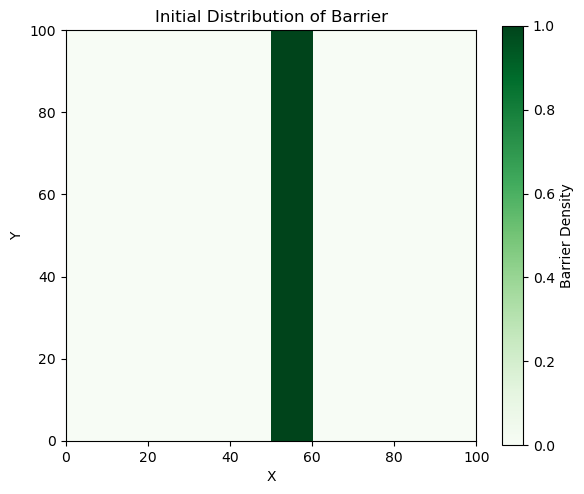

In [26]:
plot_species_distribution(V2, Lx, Ly, species_name='Deciduous')
plot_species_distribution(V1, Lx, Ly, species_name='Lichen')
plot_species_distribution(H1, Lx, Ly, species_name='Caribou')
plot_species_distribution(H2, Lx, Ly, species_name='Moose')
plot_species_distribution(P, Lx, Ly, species_name='Predator')
plot_species_distribution(k_V2, Lx, Ly, species_name='k_V2')
plot_species_distribution(k_V1, Lx, Ly, species_name='k_V1')
plot_species_distribution(barrier_mask, Lx, Ly, species_name='Barrier')


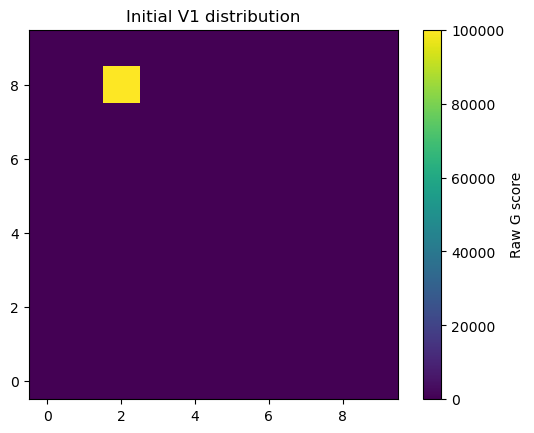

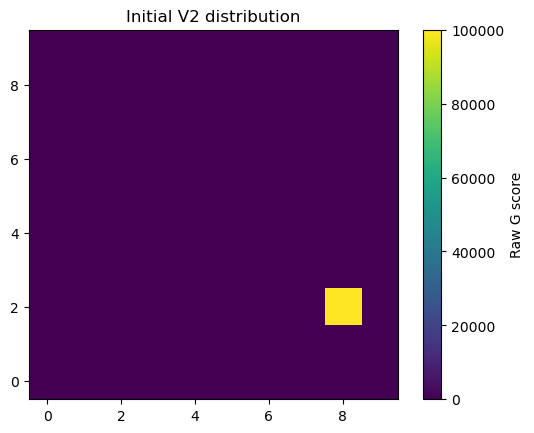

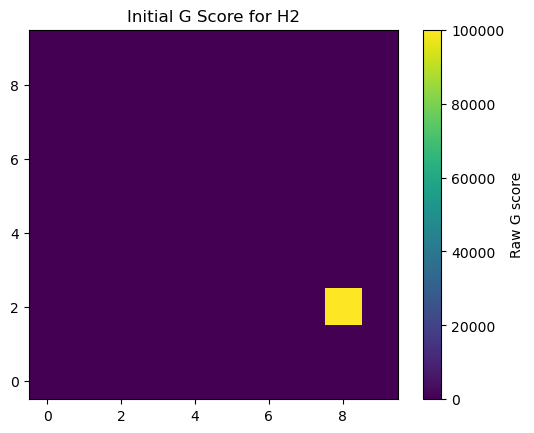

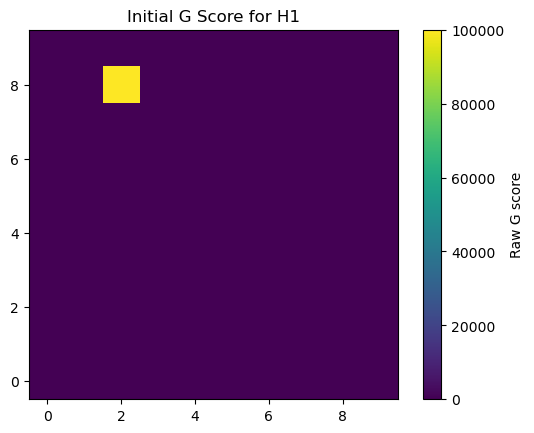

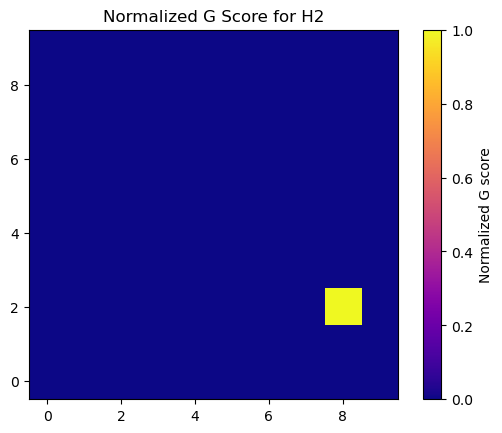

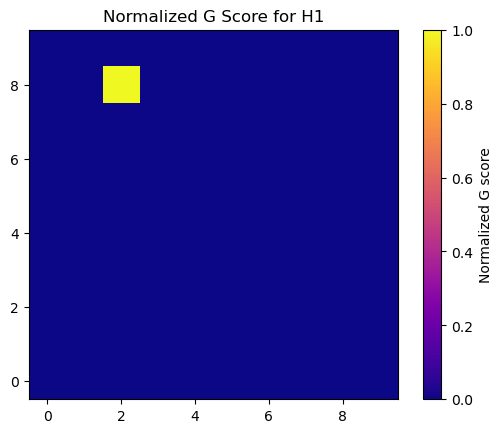

In [27]:
score_G_H2, norm_score_G_H2 = compute_norm_score_patch(
    alpha_H2H2, H2,
    alpha_H2V1, V1,
    alpha_H2V2, V2,
    alpha_PH2, P
)

score_G_H1, norm_score_G_H1 = compute_norm_score_patch(
    alpha_H1H1, H1,
    alpha_H1V1, V1,
    alpha_H1V2, V2,
    alpha_PH2, P
)

import matplotlib.pyplot as plt

plt.imshow(V1, cmap='viridis', origin='lower')
plt.colorbar(label='Raw G score')
plt.title('Initial V1 distribution')
plt.show()


plt.imshow(V2, cmap='viridis', origin='lower')
plt.colorbar(label='Raw G score')
plt.title('Initial V2 distribution')
plt.show()

plt.imshow(score_G_H2, cmap='viridis', origin='lower')
plt.colorbar(label='Raw G score')
plt.title('Initial G Score for H2')
plt.show()

plt.imshow(score_G_H1, cmap='viridis', origin='lower')
plt.colorbar(label='Raw G score')
plt.title('Initial G Score for H1')
plt.show()

plt.imshow(norm_score_G_H2, cmap='plasma', origin='lower')
plt.colorbar(label='Normalized G score')
plt.title('Normalized G Score for H2')
plt.show()

plt.imshow(norm_score_G_H1, cmap='plasma', origin='lower')
plt.colorbar(label='Normalized G score')
plt.title('Normalized G Score for H1')
plt.show()


In [28]:
# Import the diffusion function
from diffusion_fct import diff_eq
from reaction import reaction_eq_prey_mono
from reaction import reaction_eq_prey_mix
from reaction import reaction_eq_deciduous
from reaction import reaction_eq_lichen
from reaction import reaction_eq_predator


In [29]:
def flatten_fields(*fields):
    return np.concatenate([f.flatten() for f in fields])

def unflatten_fields(y, Nx, Ny, num_fields):
    split = np.split(y, num_fields)
    return [s.reshape((Nx, Ny)) for s in split]


In [30]:
def system_rhs(t, y, Nx, Ny, dx, dy, params, mask_V2, mask_V1, log_fn=None):

    V1, V2, H1, H2, P = unflatten_fields(y, Nx, Ny, 5)
    # print("Shapes:", V1.shape, V2.shape, H1.shape, H2.shape, P.shape)

    # Compute reactions
    R_V1, safe_k_V1 = reaction_eq_lichen(params['v_croiss'], V1, V2, params['k_V_norm'], 
                                    params['rho_H1'], params['a_H1'],
                                    params['h_V1H1'], params['h_V2H1'],
                                    H1)

    R_V2, safe_k_V2 = reaction_eq_deciduous(params['u_croiss'], V1, V2, params['k_U_val'],
                                    H1, H2, params['rho_H1'], params['a_H1'],
                                    params['h_V1H1'], params['h_V2H1'],
                                    params['a_H2'], params['h_V1H2'],
                                    params['h_V2H2'])

    R_H1 = reaction_eq_prey_mix(V1, V2, P, params['a_H1'],
                                    params['mu_H1'], params['rho_H1'],
                                    params['h_V1H1'], params['h_V2H1'],
                                    params['e_V1'], params['e_V2'],
                                    params['epsi_AJ'], params['k_H1'],
                                    params['chi_H1'], params['h_PH1'], params['a_PH1'],
                                    H1, H2, params['h_PH2'], params['a_PH2'])

    R_H2, r_H = reaction_eq_prey_mono(params['a_H2'], params['h_V2H2'], V2,
                                    params['chi_H2'], params['epsi_AJ'], params['e_V2'],
                                    params['mu_H2'], params['k_H2'],
                                    params['a_PH2'], P, H2,
                                    params['h_PH1'], params['a_PH1'], H1, params['h_PH2'])

    R_P = reaction_eq_predator(P, H1, H2,
                               params['a_PH1'], params['a_PH2'],
                               params['h_PH1'], params['h_PH2'],
                               params['phi_P'], params['h_P'],
                               params['chi_P'], params['epsi_H1H2'], params['mu_P'])


    # Compute diffusion
    D_H1, score_G_H1, norm_score_G_H1, Dm_eff_H1, diffusion_term_H1 = diff_eq(H1, V1, V2, P, dx, dy, sigma_H1, eta_H1, 
                         alpha_H1H1, alpha_H1V1, alpha_H1V2, alpha_PH1, barrier_mask=None)

    D_H2, score_G_H2, norm_score_G_H2, Dm_eff_H2, diffusion_term_H2 = diff_eq(H2, V1, V2, P, dx, dy, sigma_H2, eta_H2, 
                         alpha_H2H2, alpha_H2V1, alpha_H2V2, alpha_PH2, barrier_mask=None)


    if mask_V2 is not None:
        R_V2 = np.where(mask_V2, R_V2, 0)
        V2 = np.where(mask_V2, V2, 0)

    if mask_V1 is not None:
        R_V1 = np.where(mask_V1, R_V1, 0)
        V1 = np.where(mask_V1, V1, 0)


     # Log if requested
    if log_fn:
        log_fn(t, score_G_H2.copy(), Dm_eff_H2.copy())
        log_fn(t, score_G_H1.copy(), Dm_eff_H1.copy())

    # Apply the barrier mask directly to densities (to prevent "ghost" flow across the barrier)
    if barrier_mask is not None:
        V2[barrier_mask] = 0
        H2[barrier_mask] = 0
        V1[barrier_mask] = 0
        H1[barrier_mask] = 0
        R_V2[barrier_mask] = 0  # Optional: Stop any growth across the barrier
        R_H2[barrier_mask] = 0  # Optional: Stop predation or growth too
        R_V1[barrier_mask] = 0  # Optional: Stop any growth across the barrier
        R_H1[barrier_mask] = 0  # Optional: Stop predation or growth too
        diffusion_term_H1[barrier_mask] = 0
        diffusion_term_H2[barrier_mask] = 0
        

    # Calculate full derivatives
    # dV1dt = R_V1
    dV1dt = R_V1
    dV2dt = R_V2
    dH1dt = R_H1 + diffusion_term_H1
    dH2dt = diffusion_term_H2 + R_H2
    dPdt  = R_P

    dH2dt[barrier_mask] = 0  
    dV2dt[barrier_mask] = 0 
    dH1dt[barrier_mask] = 0  
    dV1dt[barrier_mask] = 0 

    return flatten_fields(dV1dt, dV2dt, dH1dt, dH2dt, dPdt) 


## Save metadata associated with the simulation

In [ ]:
from log_metadata import save_metadata

species = "H1"
params = {
    "alpha_H1V1": alpha_H1V1,
    "alpha_H1V2": alpha_H1V2,
    "alpha_H2V2": alpha_H2V2,
    "alpha_H2V1": alpha_H1V1,

    "alpha_H2H2": alpha_H2H2,
    "alpha_H1H1": alpha_H1H1,
    
    "eta_H1": eta_H1,
    "eta_H2": eta_H1,

    "sigma_H1": sigma_H1,
    "sigma_H2": sigma_H2,

    "alpha_PH2": alpha_PH2,
    "alpha_PH1": alpha_PH1
}


grid = {"Nx": Nx, "Ny": Ny, "dx": dx, "dy": dy}
sim_settings = {"Nt": Nt, "t_span": list(t_span), "solver": "LSODA"}
notes = "Testing H1 response to V1 with vertical barrier"

metadata_path = save_metadata(species, params, grid, sim_settings, notes)


In [ ]:
from scipy.integrate import solve_ivp

# Prep initial state
y0 = flatten_fields(V1, V2 , H1, H2, P)

print("y0 has NaNs?", np.any(np.isnan(y0)))
print("y0 has Infs?", np.any(np.isinf(y0)))
print("y0 min/max:", np.min(y0), np.max(y0))


t_span = (0, dt * Nt)
t_eval = np.linspace(*t_span, Nt)

# Bundle parameters
params = {
    'v_croiss': v_croiss, 'u_croiss': u_croiss,
    'k_V_norm': k_V_norm, 'k_U_val': k_U_val,
    'a_H1': a_H1, 'a_H2': a_H2,
    'h_V1H1': h_V1H1, 'h_V2H1': h_V2H1,
    'h_V1H2': h_V1H2, 'h_V2H2': h_V2H2,
    'rho_H1': rho_H1,
    'h_PH1': h_PH1, 'h_PH2': h_PH2,
    'a_PH1': a_PH1, 'a_PH2': a_PH2, 
    'chi_H1': chi_H1, 'chi_H2': chi_H2,
    'k_H2': k_H2, 'k_H1': k_H1,
    'mu_H1': mu_H1, 'mu_H2': mu_H2, 
    'e_V1': e_V1, 'e_V2': e_V2,
    'epsi_AJ': epsi_AJ, 
    'sigma_H2': sigma_H2, 'eta_H2': eta_H2, 'alpha_H2H2': alpha_H2H2,
    'alpha_H2V1': alpha_H2V1, 'alpha_H2V2': alpha_H2V2,'alpha_PH2': alpha_PH2,
    'mu_P': mu_P, 'phi_P': phi_P, 'h_P': h_P,
    'chi_P': chi_P, 'epsi_H1H2': epsi_H1H2,
    
}

# 4. Initialize logs BEFORE defining the function
logged_score_G_H2 = []
logged_Dm_eff_H2 = []
logged_score_G_H1 = []
logged_Dm_eff_H1 = []


# 5. Define the logging function
def log_intermediates(t, score_G, Dm_eff):
    logged_score_G_H2.append((t, score_G.copy()))
    logged_Dm_eff_H2.append((t, Dm_eff.copy()))
    logged_score_G_H1.append((t, score_G.copy()))
    logged_Dm_eff_H1.append((t, Dm_eff.copy()))

# 6. Call solver and pass log function
sol = solve_ivp(
    fun=lambda t, y: system_rhs(t, y, Nx, Ny, dx, dy, params, mask_V2, mask_V1, log_fn=log_intermediates),
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method='LSODA'
)

y0 has NaNs? False
y0 has Infs? False
y0 min/max: 0.0 100000.0


In [ ]:
import numpy as np

# Number of spatial points
N = Nx * Ny

# Convert sol.y to numpy array (if not already)
y_array = np.array(sol.y)

# Reshape each species
V1_over_time = y_array[0        : N,     :].reshape(Nx, Ny, -1)  # shape (Nx, Ny, Nt)
V2_over_time = y_array[N        : 2*N,   :].reshape(Nx, Ny, -1)
H1_over_time = y_array[2*N      : 3*N,   :].reshape(Nx, Ny, -1)
H2_over_time = y_array[3*N      : 4*N,   :].reshape(Nx, Ny, -1)
P_over_time  = y_array[4*N      : 5*N,   :].reshape(Nx, Ny, -1)



## Temporal dynamics

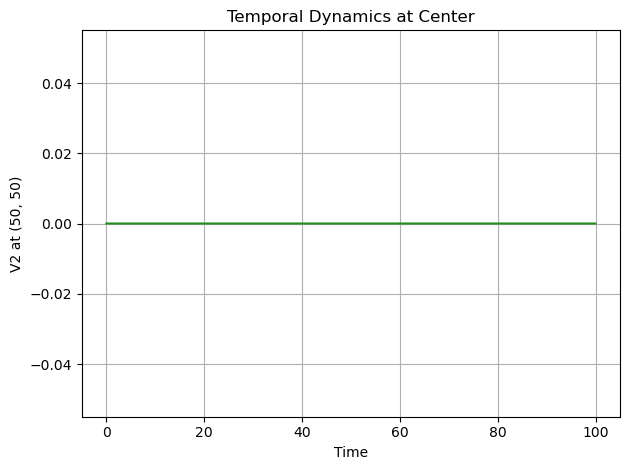

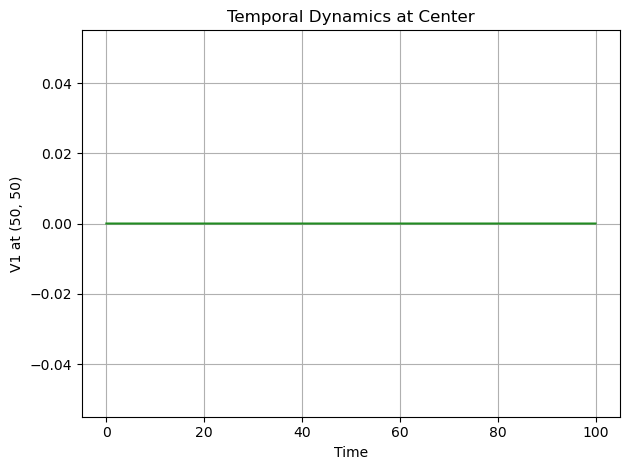

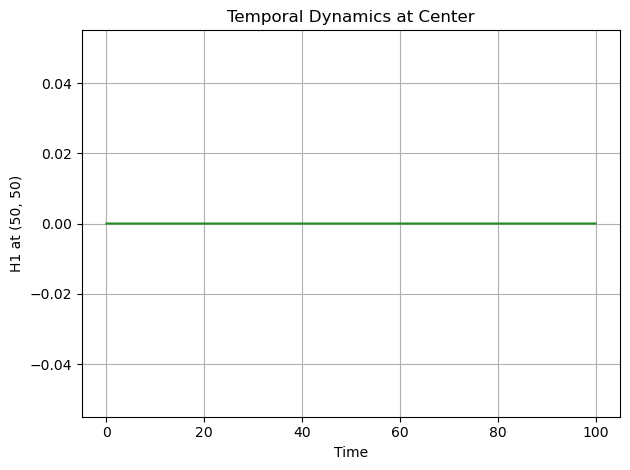

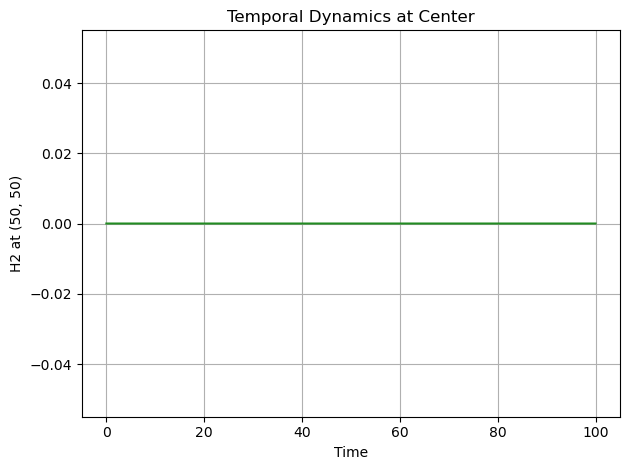

In [ ]:
V2_center = V2_over_time[Nx//2, Ny//2, :]  # Shape: (Nt,)
plt.plot(sol.t, V2_center, color='forestgreen')
plt.xlabel('Time')
plt.ylabel('V2 at (50, 50)')
plt.title('Temporal Dynamics at Center')
plt.grid(True)
plt.tight_layout()
plt.show()

V1_center = V1_over_time[Nx//2, Ny//2, :]  # Shape: (Nt,)
plt.plot(sol.t, V1_center, color='forestgreen')
plt.xlabel('Time')
plt.ylabel('V1 at (50, 50)')
plt.title('Temporal Dynamics at Center')
plt.grid(True)
plt.tight_layout()
plt.show()

H1_center = H1_over_time[Nx//2, Ny//2, :]  # Shape: (Nt,)
plt.plot(sol.t, H1_center, color='forestgreen')
plt.xlabel('Time')
plt.ylabel('H1 at (50, 50)')
plt.title('Temporal Dynamics at Center')
plt.grid(True)
plt.tight_layout()
plt.show()

H2_center = H2_over_time[Nx//2, Ny//2, :]  # Shape: (Nt,)
plt.plot(sol.t, H2_center, color='forestgreen')
plt.xlabel('Time')
plt.ylabel('H2 at (50, 50)')
plt.title('Temporal Dynamics at Center')
plt.grid(True)
plt.tight_layout()
plt.show()


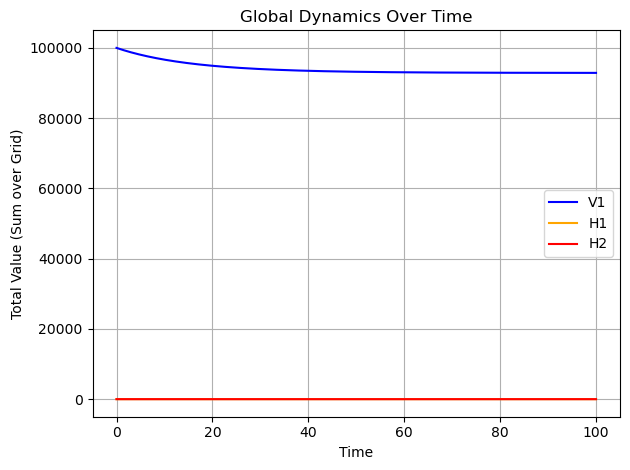

In [ ]:
V2_sum = np.sum(V2_over_time, axis=(0, 1))  # Sum across x and y, keeping time
V1_sum = np.sum(V1_over_time, axis=(0, 1))
H1_sum = np.sum(H1_over_time, axis=(0, 1))
H2_sum = np.sum(H2_over_time, axis=(0, 1))

# plt.plot(sol.t, V2_sum, label='V2', color='green')
plt.plot(sol.t, V1_sum, label='V1', color='blue')
plt.plot(sol.t, H1_sum, label='H1', color='orange')
plt.plot(sol.t, H2_sum, label='H2', color='red')
plt.xlabel('Time')
plt.ylabel('Total Value (Sum over Grid)')
plt.title('Global Dynamics Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Base folder for all time series plots
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
base_output_dir = os.path.join("outputs", f"{timestamp}", "global_time_series")


# Loop over species
species_list = ["H1", "H2", "V1", "V2"]
for species_name in species_list:
    
    # Retrieve time series data
    species_field = globals()[f"{species_name}_over_time"]
    species_sum = np.sum(species_field, axis=(0, 1))

    # Set parameter values
    if species_name == "H1":
        alpha_V1 = alpha_H1V1
        alpha_V2 = alpha_H1V2
        eta = eta_H1
        color = "orange"
    elif species_name == "H2":
        alpha_V1 = alpha_H2V1
        alpha_V2 = alpha_H2V2
        eta = eta_H2
        color = "red"
    elif species_name == "V1":
        alpha_V1 = alpha_V2 = eta = 0.0
        color = "blue"
    elif species_name == "V2":
        alpha_V1 = alpha_V2 = eta = 0.0
        color = "green"
    else:
        continue

    # Create species-specific folder
    species_dir = os.path.join(base_output_dir, species_name)
    os.makedirs(species_dir, exist_ok=True)

    # Create and save figure
    filename = f"{species_name}_alphaV1_{alpha_V1:.2f}_alphaV2_{alpha_V2:.2f}_eta_{eta:.2f}.png"
    filepath = os.path.join(species_dir, filename)

    plt.figure()
    plt.plot(sol.t, species_sum, label=species_name, color=color)
    plt.xlabel("Time")
    plt.ylabel("Total Value (Sum over Grid)")
    plt.title(f"{species_name} Dynamics Over Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close()


## Spatial dynamics

In [ ]:
max_t_idx = V2_over_time.shape[2] - 1
print("Maximum valid t_idx:", max_t_idx)

Maximum valid t_idx: 9999


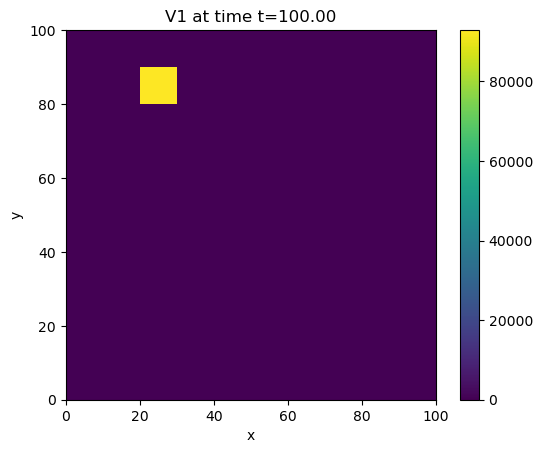

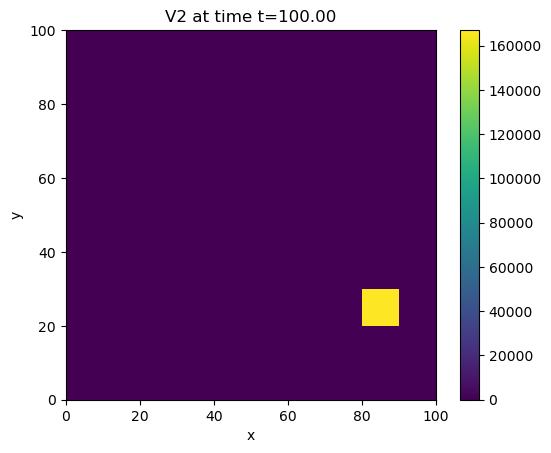

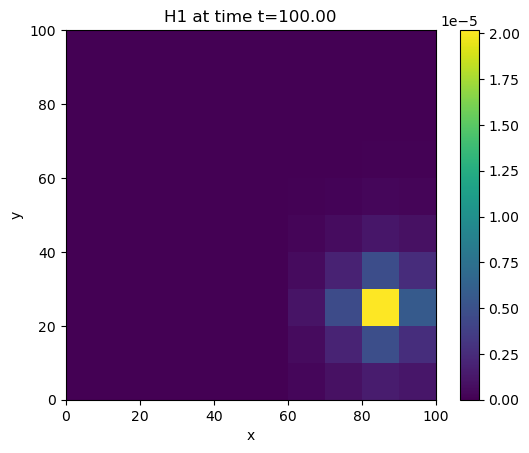

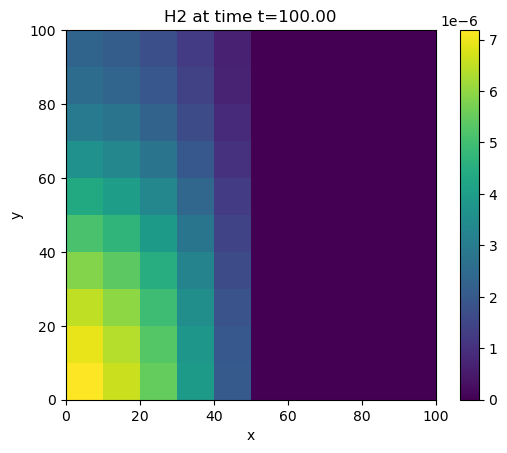

In [ ]:
import matplotlib.pyplot as plt

t_idx = max_t_idx

# Define plotting function for clarity
def plot_field(field, title, t_idx, t_eval, Lx, Ly):
    plt.imshow(field[:, :, t_idx], cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower')
    plt.colorbar()
    plt.title(f"{title} at time t={t_eval[t_idx]:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# Example usage:
plot_field(V1_over_time, "V1", t_idx, t_eval, Lx, Ly)
plot_field(V2_over_time, "V2", t_idx, t_eval, Lx, Ly)
plot_field(H1_over_time, "H1", t_idx, t_eval, Lx, Ly)
plot_field(H2_over_time, "H2", t_idx, t_eval, Lx, Ly)

## Define diffusion parameters

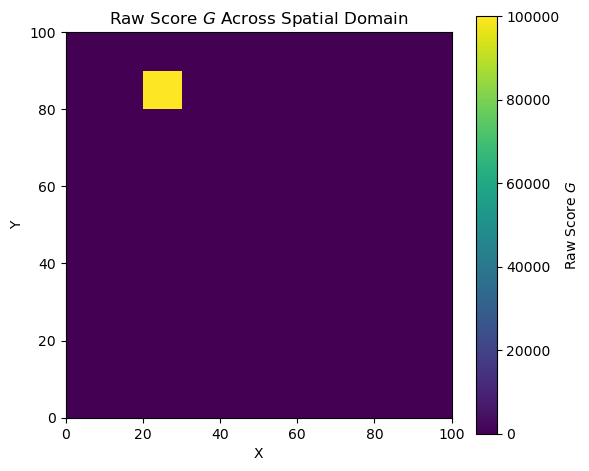

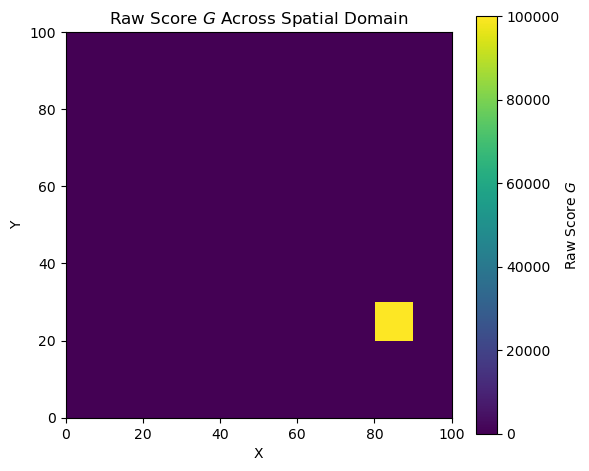

In [ ]:
import matplotlib.pyplot as plt

def visualize_score(score_G, Lx, Ly):
    plt.figure(figsize=(6, 5))
    plt.imshow(score_G, origin='lower', extent=[0, Lx, 0, Ly], cmap='viridis')
    plt.colorbar(label='Raw Score $G$')
    plt.title('Raw Score $G$ Across Spatial Domain')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


visualize_score(score_G_H1, Lx, Ly)
visualize_score(score_G_H2, Lx, Ly)

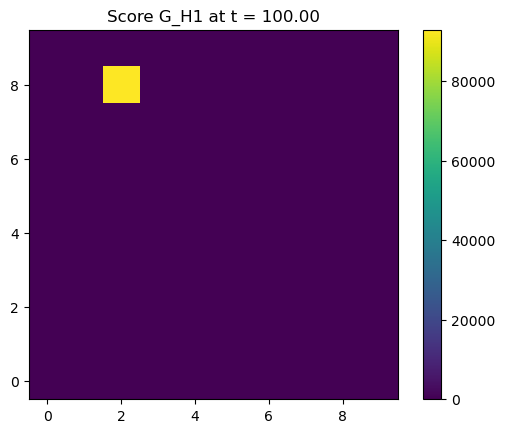

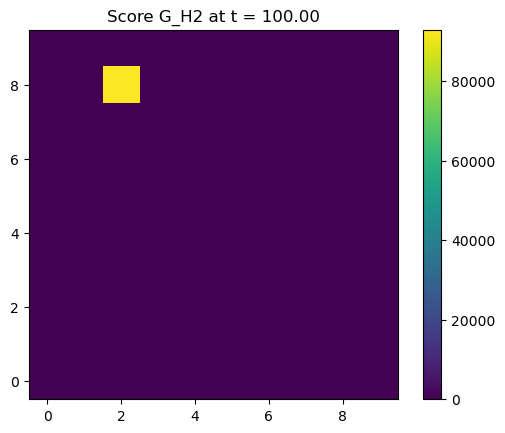

In [ ]:
import matplotlib.pyplot as plt

# For example, plot score_G_H1 at final time:
t_last, score_last = logged_score_G_H1[-1]
plt.imshow(score_last, cmap="viridis", origin='lower')
plt.title(f"Score G_H1 at t = {t_last:.2f}")
plt.colorbar()
plt.show()

# For example, plot score_G_H2 at final time:
t_last, score_last = logged_score_G_H2[-1]
plt.imshow(score_last, cmap="viridis", origin='lower')
plt.title(f"Score G_H2 at t = {t_last:.2f}")
plt.colorbar()
plt.show()



## Follow dynamics through time

In [ ]:
import os
import matplotlib.pyplot as plt

# Choose your species
species_name = "H2"
species_field = globals()[f"{species_name}_over_time"]

# Extract parameter values associated with the species
if species_name == "H1":
    alpha_V1 = alpha_H1V1
    alpha_V2 = alpha_H1V2
    eta = eta_H1
elif species_name == "H2":
    alpha_V1 = alpha_H2V1
    alpha_V2 = alpha_H2V2
    eta = eta_H2
else:
    raise ValueError(f"Unknown species: {species_name}")

# Create folder name from parameters

from datetime import datetime

# Base folder for all time series plots
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
folder_label = f"alphaV1_{alpha_V1:.2f}_alphaV2_{alpha_V2:.2f}_eta_{eta:.2f}"
output_dir = os.path.join("outputs", f"{timestamp}", f"frames_{species_name}", folder_label)
os.makedirs(output_dir, exist_ok=True)

# Frame-saving function
def save_frame(field, title, t_idx, t_eval, Lx, Ly, filename):
    plt.imshow(field[:, :, t_idx], cmap='viridis', extent=[0, Lx, 0, Ly], origin='lower')
    plt.colorbar()
    plt.title(f"{title} at time t={t_eval[t_idx]:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Save sampled frames
total_frames = 50
step = max(1, species_field.shape[2] // total_frames)
selected_indices = list(range(0, species_field.shape[2], step))[:total_frames]

for i, t_idx in enumerate(selected_indices):
    fname = os.path.join(output_dir, f"{species_name}_{i:04d}.png")
    save_frame(species_field, species_name, t_idx, t_eval, Lx, Ly, fname)


In [ ]:
import imageio.v2 as imageio
import os

# Match the species name and corresponding parameters
species_name = "H2"

if species_name == "H1":
    alpha_V1 = alpha_H1V1
    alpha_V2 = alpha_H1V2
    eta = eta_H1
elif species_name == "H2":
    alpha_V1 = alpha_H2V1
    alpha_V2 = alpha_H2V2
    eta = eta_H2
else:
    raise ValueError(f"Unknown species: {species_name}")

# Use the same parameter-aware folder as during frame generation

from datetime import datetime

# Base folder for all time series plots
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S"

folder_label = f"alphaV1_{alpha_V1:.2f}_alphaV2_{alpha_V2:.2f}_eta_{eta:.2f}"
output_dir = os.path.join("outputs", f"{timestamp}", f"frames_{species_name}", folder_label)

# Output folder for GIFs
gif_dir = os.path.join("outputs", f"{timestamp}", "GIF")
os.makedirs(gif_dir, exist_ok=True)

# Number of frames and file loading
n_frames = 50
images = []
for i in range(n_frames):
    fname = os.path.join(output_dir, f"{species_name}_{i:04d}.png")
    images.append(imageio.imread(fname))

# Save the animation
output_gif_path = os.path.join(gif_dir, f"{species_name}_{folder_label}.gif")
imageio.mimsave(output_gif_path, images, duration=0.2)


## Display dynamics of all species currently in the system

In [ ]:
def save_overlay_frame(H1_field, H2_field, t_idx, t_eval, Lx, Ly, filename, barrier_mask):
    # Create figure
    plt.figure()

    # Plot H1 and assign mappable
    h1_plot = plt.imshow(H1_field[:, :, t_idx], cmap='Blues', alpha=0.6,
                         extent=[0, Lx, 0, Ly], origin='lower')

    # Plot H2
    plt.imshow(H2_field[:, :, t_idx], cmap='Reds', alpha=0.6,
               extent=[0, Lx, 0, Ly], origin='lower')

    # Overlay barrier
    plt.contour(barrier_mask, levels=[0.5], colors='black', linewidths=2,
                extent=[0, Lx, 0, Ly])

    # Plot details
    plt.title(f"H1 and H2 overlay at t={t_eval[t_idx]:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(h1_plot)  # Explicit mappable from H1
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# Folder for overlays
overlay_dir = os.path.join("outputs", "frames_overlay_H1_H2")
os.makedirs(overlay_dir, exist_ok=True)

for i, t_idx in enumerate(selected_indices):
    fname = os.path.join(overlay_dir, f"H1_H2_overlay_{i:04d}.png")
    save_overlay_frame(H1_over_time, H2_over_time, t_idx, t_eval, Lx, Ly, fname, barrier_mask)



In [ ]:
import imageio.v2 as imageio
import os

# Frame folder (overlay version)
overlay_dir = os.path.join("outputs", "frames_overlay_H1_H2")
gif_output_dir = os.path.join("outputs", "GIF")
os.makedirs(gif_output_dir, exist_ok=True)

# Assemble GIF from saved overlays
n_frames = 50  # match total_frames from frame creation
images = []
for i in range(n_frames):
    fname = os.path.join(overlay_dir, f"H1_H2_overlay_{i:04d}.png")
    images.append(imageio.imread(fname))

# Save the animation
gif_path = os.path.join(gif_output_dir, "H1_H2_overlay_animation.gif")
imageio.mimsave(gif_path, images, duration=0.2)
